In [4]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

sys.path.append(os.path.abspath("../../function"))
from others import haversine, relative_error, NMAE, NMSE, PSS, spearman_corr, MAE, RMSE

In [5]:
year = 2024

In [6]:
product = 'NRT'

In [7]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil')

In [8]:
DATA = xr.open_dataset(os.path.join(dir_base,'GSMaP',product,f'GSMaP_{product}_BR_1h_2024_01_01_2024_12_31.nc'))
DATA = DATA.sel(time=slice(f"{year}-01-01", "{year}-12-31"))

lon = DATA.lon.values
lat = DATA.lat.values
lon2d, lat2d = np.meshgrid(lon, lat)

SAT_time = pd.to_datetime(DATA.time.values)
print(f'Number of times: {len(SAT_time)}')

PRE = DATA.PRE.values

del DATA

Number of times: 8784


In [9]:
INFO = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','1hr',f'{year}',f'INFO_{year}.csv'))
print(f'NUmber of files: {len(INFO)}')

NUmber of files: 3483


In [30]:
NMAE_all, NMSE_all, PSS_all = [], [], []
MAE_all, RMSE_all = [], []
lat_ref, lon_ref = [], []
COR_all = []
RE = []

for nn in range(len(INFO)):#len(INFO)

    namein = f'obs_cptec_{INFO.code[nn]}.csv'
    try:
        obs = pd.read_csv(os.path.join(dir_base,'OBS_CPTEC','1hr',f'{year}','rdy',namein))

        obs['date'] = pd.to_datetime(obs['date'])
        obs = obs.drop_duplicates(subset='date', keep='first')

        start = '2024-01-01 00:00'
        end = '2024-12-31 23:00'
        obs_filtered = obs[(obs['date'] >= start) & (obs['date'] <= end)]
        obs_filtered = obs_filtered.reset_index(drop=True)

        PRE_obs = obs_filtered['r'].values

        lat_obs = INFO.lat.values[nn]
        lon_obs = INFO.lon.values[nn]

        if lon_obs > -33:
            continue

        else:
            lat_ref.append(lat_obs)
            lon_ref.append(lon_obs)

            distances = haversine(lon2d, lat2d, lat_obs, lon_obs)
            min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

            PRE_sat = PRE[:,min_index[0],min_index[1]] 

            DATA_pd = pd.DataFrame({'Time':SAT_time, 'OBS':PRE_obs, 'SAT':PRE_sat})
            DATA_pd['Time'] = pd.to_datetime(DATA_pd['Time'])
            DATA_pd = DATA_pd.dropna(subset=['SAT', 'OBS'])

            PRE_sat_rdy = DATA_pd.SAT.values
            PRE_obs_rdy = DATA_pd.OBS.values

            NMAE_tmp = NMAE(PRE_sat_rdy,PRE_obs_rdy)
            NMSE_tmp = NMSE(PRE_sat_rdy,PRE_obs_rdy)

            MAE_tmp = MAE(PRE_sat_rdy,PRE_obs_rdy)
            RMSE_tmp = RMSE(PRE_sat_rdy,PRE_obs_rdy)

            PSS_tmp = PSS(PRE_sat_rdy,PRE_obs_rdy)
            COR_tmp = spearman_corr(PRE_sat_rdy,PRE_obs_rdy)

            NMAE_all.append(float(NMAE_tmp))
            NMSE_all.append(float(NMSE_tmp))
            MAE_all.append(float(MAE_tmp))
            RMSE_all.append(float(RMSE_tmp))
            PSS_all.append(float(PSS_tmp))
            COR_all.append(float(COR_tmp))

            RE_ = relative_error(PRE_sat_rdy, PRE_obs_rdy)
            RE.append(RE_)

    except:
        continue

RE = np.concatenate([m.flatten() for m in RE])

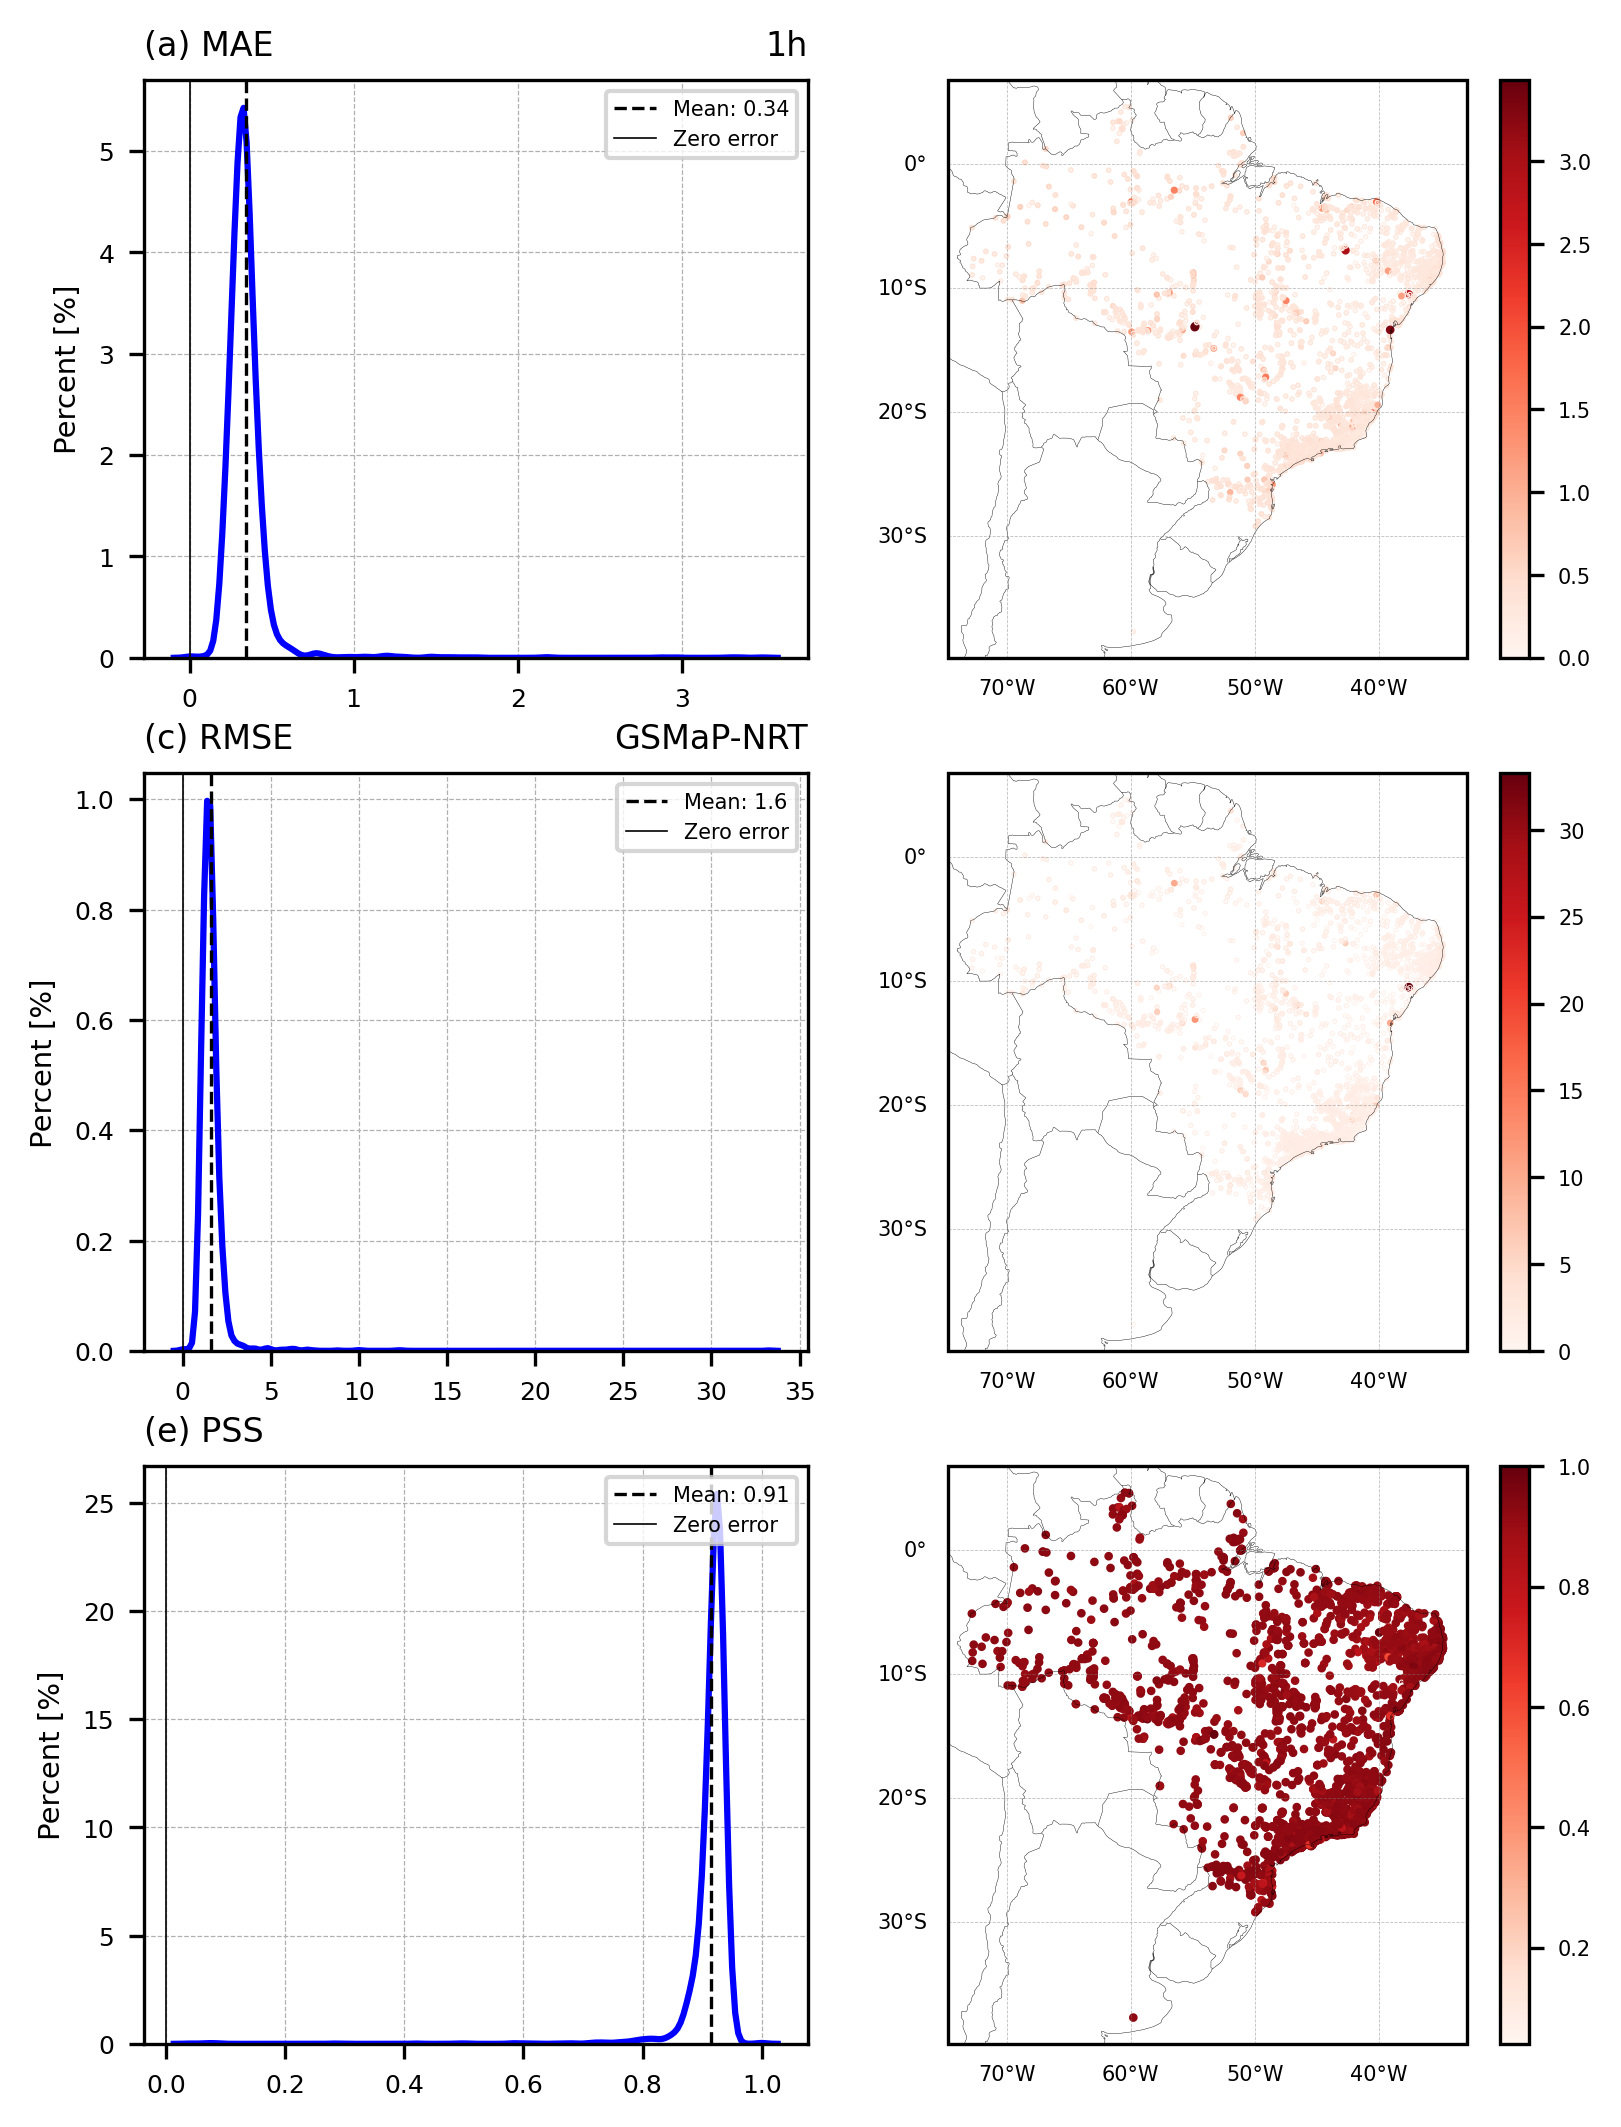

In [54]:
levels = np.arange(0, 30, 5)
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)
norm = None

proj = ccrs.PlateCarree()
cmap = plt.cm.Reds

fig = plt.figure(figsize=(6,8.5),dpi=300)
gs = gridspec.GridSpec(3,2)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0])
sns.kdeplot(MAE_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.mean(MAE_all),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(MAE_all),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
# ax1.set_xlim(-5,35)
# ax1.set_xticklabels([])
ax1.set_title('(a) MAE', loc='left', fontsize=8)
ax1.set_title('1h', loc='right', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(MAE_all/np.nanmax(MAE_all)),marker='.',c=MAE_all,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[1, 0])
sns.kdeplot(RMSE_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.mean(RMSE_all),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(RMSE_all),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
# ax1.set_xlim(-5,35)
# ax1.set_xticklabels([])
ax1.set_title('(c) RMSE', loc='left', fontsize=8)
ax1.set_title('GSMaP-NRT', loc='right', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(RMSE_all/np.nanmax(RMSE_all)),marker='.',c=RMSE_all,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
ax1 = plt.subplot(gs[2, 0])
sns.kdeplot(PSS_all,color='blue',cumulative=False,fill=False,multiple="stack",ax=ax1)
ax1.axvline(np.mean(PSS_all),color='k',linestyle='--',linewidth=0.8, label=f'Mean: {np.round(np.mean(PSS_all),2)}')
ax1.axvline(0,color='k',linestyle='-',linewidth=0.4, label=f'Zero error')
ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
# ax1.set_xlim(-5,35)
ax1.set_title('(e) PSS', loc='left', fontsize=8)
ax1.legend(fontsize=5,loc=1)

#================================================================================
ax1 = plt.subplot(gs[2, 1], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.left_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

a1 = ax1.scatter(lon_ref,lat_ref,s=5*(PSS_all/np.nanmax(PSS_all)),marker='.',c=PSS_all,cmap=cmap,norm=norm)
cbar = plt.colorbar(a1, fraction=0.058)
cbar.ax.tick_params(labelsize=5)

#==================================================================================================
plt.subplots_adjust(wspace=0.1, hspace=0.2)

ax1.set_facecolor('white')
fig.patch.set_alpha(0)